In [1]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [2]:
!pip install gdown==5.1.0

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [3]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 120MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 99.2MB/s]


In [4]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

In [5]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

In [6]:
# Parse Data

def parse_data_from_input(filename):
  with open(filename) as file:


    csv_reader = csv.reader(file, delimiter=',')

    labels = []
    images = []

    # Skip header
    next(csv_reader, None)

    for row in csv_reader:
      label = row[0]
      image = row[1:]
      image = np.reshape(image, (28, 28))

      labels.append(label)
      images.append(image)

    labels = np.array(labels).astype('float')
    images = np.array(images).astype('float')


    return images, labels

In [7]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


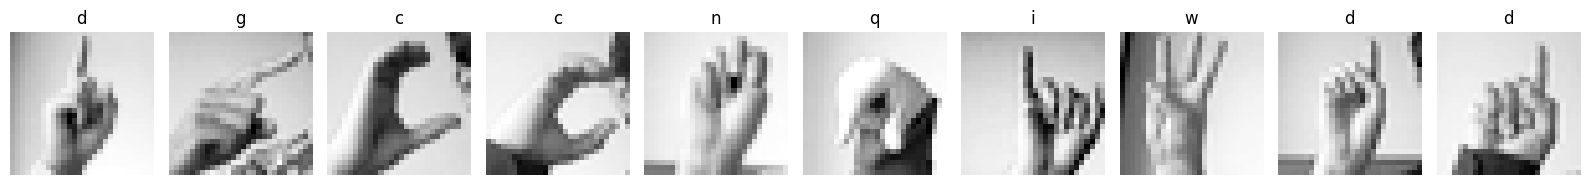

In [8]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

In [9]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators

  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  training_images = np.expand_dims(training_images, axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)

  # Instantiate the ImageDataGenerator class for training data with normalization and augmentation
  train_datagen = ImageDataGenerator(rescale=1./255.,
                                      rotation_range=15,
                                      width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      shear_range=0.1,
                                      #zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

  # Prepare the training data generator
  train_generator = train_datagen.flow(x=training_images,
                                        y=training_labels,
                                        batch_size=32)

  # Instantiate the ImageDataGenerator class for validation data with only normalization
  validation_datagen = ImageDataGenerator(rescale=1./255.)

  # Prepare the validation data generator
  validation_generator = validation_datagen.flow(x=validation_images,
                                                  y=validation_labels,
                                                  batch_size=32)



  return train_generator, validation_generator

In [10]:
# Test generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


In [11]:
def create_model():

  # Use no more than 2 Conv2D and 2 MaxPooling2D
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation='relu'),
    # 25 classes
    tf.keras.layers.Dense(25, activation='softmax')
  ])


  model.compile(optimizer = 'rmsprop',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


  return model

In [12]:
# Save the model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 20s 18ms/step - loss: 1.6569 - accuracy: 0.4826 - val_loss: 0.3938 - val_accuracy: 0.8696
Epoch 2/15
858/858 [==============================] - 15s 17ms/step - loss: 0.3821 - accuracy: 0.8728 - val_loss: 0.1732 - val_accuracy: 0.9254
Epoch 3/15
858/858 [==============================] - 15s 18ms/step - loss: 0.1908 - accuracy: 0.9359 - val_loss: 0.0588 - val_accuracy: 0.9816
Epoch 4/15
858/858 [==============================] - 14s 17ms/step - loss: 0.1241 - accuracy: 0.9599 - val_loss: 0.0191 - val_accuracy: 0.9922
Epoch 5/15
858/858 [==============================] - 15s 17ms/step - loss: 0.0894 - accuracy: 0.9712 - val_loss: 0.0218 - val_accuracy: 0.9923
Epoch 6/15
858/858 [==============================] - 15s 17ms/step - loss: 0.0704 - accuracy: 0.9771 - val_loss: 0.0086 - val_accuracy: 0.9964
Epoch 7/15
858/858 [==============================] - 15s 18ms/step - loss: 0.0645 - accuracy: 0.9792 - val_loss: 0.0269 - val_accuracy:

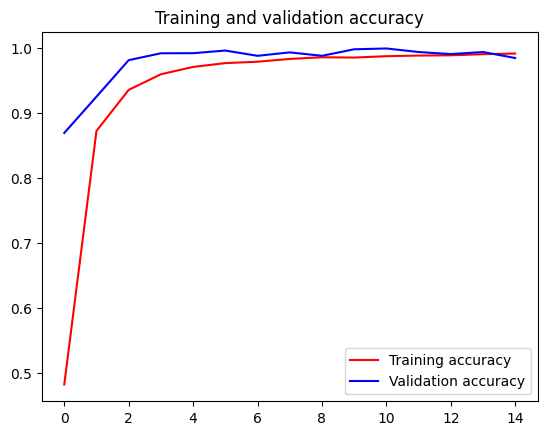

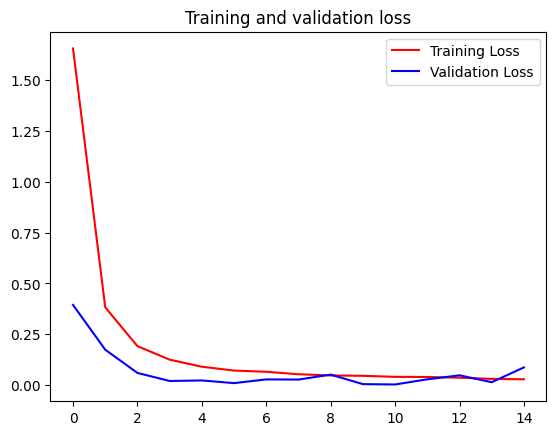

In [13]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()